In [9]:
!pip install pandas numpy matplotlib yfinance

Active code page: 437



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Strategy: SMA
Trades: 3
Avg holding period: 32.666666666666664
Win trades: 1
Lose trades: 2
Stop losses: 0
Total profit: -11.97
Avg profit: -3.99
Avg RoR %%: -2.23 %
Win rate %: 33.33333333333333
1-day 99% VaR: 5.099738736947536
    Buy Date  Buy Signal Price  Sell Date  Sell Signal Price  Holding Days   
1 2022-03-28            175.60 2022-04-22             161.79            25  \
2 2022-07-15            150.17 2022-09-09             157.37            56   
3 2022-11-21            148.01 2022-12-08             142.65            17   

  Profit  RoR %  Win  Lose  Stop Loss  
1 -13.81  -7.86    0     1          0  
2   +7.2  +4.79    1     0          0  
3  -5.36  -3.62    0     1          0  


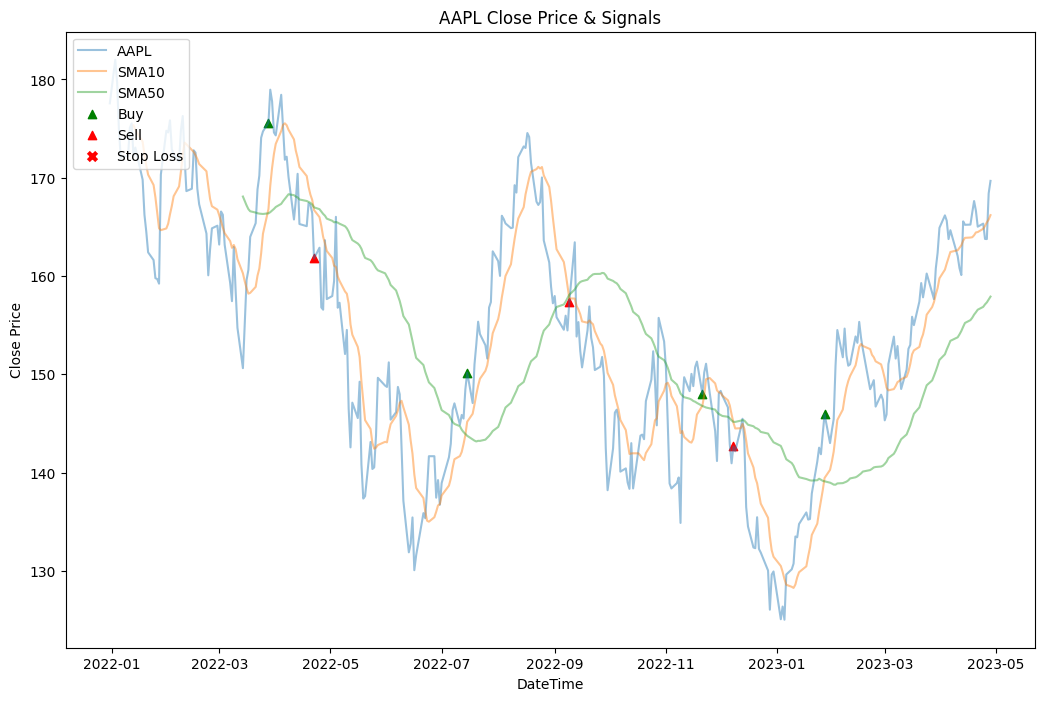

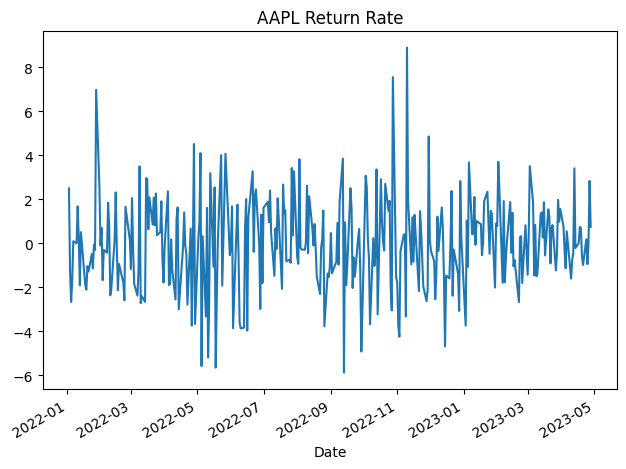

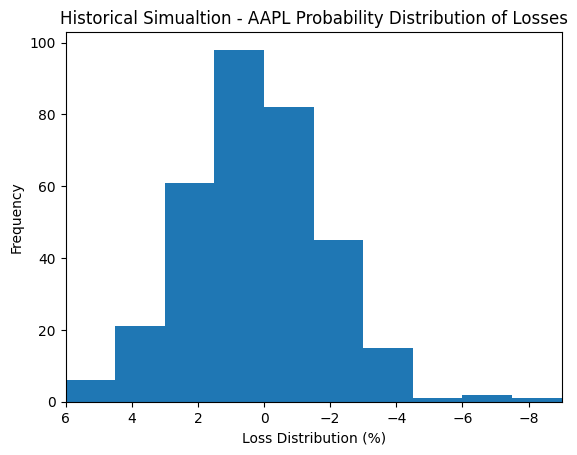

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

class SMA_Strategy:
    """
    A class for analyzing stock data using sma.
    """
    def __init__(self, ticker, start='2015-01-01', end="2022-01-01", sma_short=50, sma_long=200, stop_loss=True, stop_loss_percent=0.08):
        """
        ticker: stock code
        start: start day
        end: end day
        sma_short: eg.SMA50
        sma_long: eg.SMA200
        stop_loss: Set True if having a stop_loss_percent
        stop_loss_percent: loss percentage compared to the buying price
        """
        self.ticker = ticker
        self.start = start
        self.end = end
        self.sma_short = sma_short
        self.sma_long = sma_long
        self.stop_loss = stop_loss
        self.stop_loss_percent = stop_loss_percent

    def download_data(self):
        """
        Download source data
        """
        return yf.download(self.ticker, start=self.start, end=self.end, progress=False).dropna()

    def buy_sell(self, data):
        """
        Buy and Sell signal
        """
        buy_signal = []
        sell_signal = []
        stop_loss_signal = []
        flag = -1
        stop_loss_price = 0
        stop_loss = self.stop_loss
        stop_loss_percent = self.stop_loss_percent
        for i in range(len(data)):
            if data[f'SMA{self.sma_short}'][i] > data[f'SMA{self.sma_long}'][i] and data['Ticker'][i] > stop_loss_price:
                stop_loss_signal.append(np.nan)
                if flag == 0:
                    buy_signal.append(data['Ticker'][i])
                    if stop_loss:
                        stop_loss_price = data['Ticker'][i] * (1 - stop_loss_percent)
                    sell_signal.append(np.nan)
                    flag = 1
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
            elif data[f'SMA{self.sma_short}'][i] < data[f'SMA{self.sma_long}'][i] or data['Ticker'][i] < stop_loss_price:
                if flag == 1:
                    buy_signal.append(np.nan)
                    sell_signal.append(data['Ticker'][i])
                    flag = -1
                    if data['Ticker'][i] < stop_loss_price:
                        stop_loss_signal.append(data['Ticker'][i])
                    else:
                        stop_loss_signal.append(np.nan)
                    stop_loss_price = 0
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
                    stop_loss_signal.append(np.nan)
                if data[f'SMA{self.sma_short}'][i] < data[f'SMA{self.sma_long}'][i]:
                    flag = 0
            else:
                buy_signal.append(np.nan)
                sell_signal.append(np.nan)
                stop_loss_signal.append(np.nan)
        self.data = data
        return buy_signal, sell_signal, stop_loss_signal

    def plot_data(self):
        """
        Plots the stock data and the SMA strategy.
        """
        data = self.data
        plt.figure(figsize=(12.5, 8))
        plt.plot(data['Ticker'], label=self.ticker.upper(), alpha=0.45)
        plt.plot(data[f'SMA{self.sma_short}'], label=f'SMA{self.sma_short}', alpha=0.45)
        plt.plot(data[f'SMA{self.sma_long}'], label=f'SMA{self.sma_long}', alpha=0.45)
        plt.scatter(data.index, data['Buy_Signal_Price'], label='Buy', marker='^', color='green')
        plt.scatter(data.index, data['Sell_Signal_Price'], label='Sell', marker='^', color='red')
        plt.scatter(data.index, data['Stop_Loss'], label='Stop Loss', marker='x', color='red', linewidth=3)
        plt.legend(loc='upper left')
        plt.title(f'{self.ticker.upper()} Close Price & Signals')
        plt.xlabel('DateTime')
        plt.ylabel('Close Price')
        plt.show()

        data['return'].plot(title=f'{self.ticker} Return Rate')
        plt.tight_layout()
        plt.show()

        # Creating dataset
        import math
        a = np.array(data['loss'])
        rounded_arr = [round(x * 2) / 2 for x in a if not math.isnan(x)]
        counts = {}
        for element in rounded_arr:
            counts[element] = counts.get(element, 0) + 1
        counts = dict(reversed(sorted(counts.items())))
        labels = list(counts.keys())
        values = list(counts.values())
        
        plt.hist(labels, weights=values)
        plt.xlim(max(labels), min(labels))
        plt.xlabel('Loss Distribution (%)')
        plt.ylabel('Frequency')
        plt.title(f'Historical Simualtion - {self.ticker} Probability Distribution of Losses')
        plt.show()

    def historical_simulation(self, data, percentile=0.99):
        latest_price = data['close'].iat[-1]
        number_of_share = 100 / latest_price
        simulation = latest_price * data['close'] / data['close'].shift(1)
        data['loss'] = 100 - simulation * number_of_share
        var_99_percent = data['loss'].quantile(percentile)
        return var_99_percent

    def analyze_performance(self):
        """
        Analyzes the performance of the SMA strategy.
        """
        data = self.data
        buy = data['Buy_Signal_Price'].dropna().reset_index(drop=False)
        sell = data['Sell_Signal_Price'].dropna().reset_index(drop=False)
        stop_loss = data['Stop_Loss'].dropna().reset_index(drop=False)
        merged_df = buy.join(sell, lsuffix='_Buy', rsuffix='_Sell')
        merged_df = merged_df[['Date_Buy', 'Buy_Signal_Price', 'Date_Sell', 'Sell_Signal_Price']].dropna()
        merged_df['Holding Days'] = (merged_df['Date_Sell'] - merged_df['Date_Buy']).dt.days.astype(int)
        merged_df['Profit'] = merged_df['Sell_Signal_Price'] - merged_df['Buy_Signal_Price']
        merged_df['RoR %'] = merged_df['Profit'] / merged_df['Buy_Signal_Price'] * 100
        merged_df['Win'] = (merged_df['Profit'] > 0).astype(int)
        merged_df['Lose'] = (merged_df['Profit'] <= 0).astype(int)
        merged_df['Stop Loss'] = merged_df['Date_Sell'].isin(stop_loss['Date']).astype(int)

        num_trades = len(merged_df)
        profitable_trades = merged_df['Win'].sum()
        losing_trades = merged_df['Lose'].sum()
        total_profit = merged_df['Profit'].sum()
        stop_loss = merged_df['Stop Loss'].sum()
        
        if num_trades > 0:
            win_probability = profitable_trades / num_trades * 100
            average_holding_days = merged_df['Holding Days'].mean()
            average_profit = merged_df['Profit'].mean()
            average_ror = merged_df['RoR %'].mean()
        else:
            win_probability = 0
            average_holding_days = 0
            average_ror = 0
            average_profit = 0

        var_99_percent = self.historical_simulation(data)

        print('Strategy: SMA')
        print(f"Trades: {num_trades}")
        print(f"Avg holding period: {average_holding_days}")
        print(f"Win trades: {profitable_trades}")
        print(f"Lose trades: {losing_trades}")
        print(f"Stop losses: {stop_loss}")
        print(f"Total profit: {total_profit:.2f}")
        print(f"Avg profit: {average_profit:.2f}")
        print(f"Avg RoR %%: {average_ror:.2f} %")
        print(f"Win rate %: {win_probability}")     
        print(f"1-day 99% VaR: {var_99_percent}")     

        merged_df.rename({'Date_Buy': 'Buy Date', 'Buy_Signal_Price': 'Buy Signal Price', 'Date_Sell': 'Sell Date', 'Sell_Signal_Price': 'Sell Signal Price'}, axis=1, inplace=True)
        merged_df.index += 1
        data_detail = merged_df.round(decimals=2)
        data_detail['Profit'] = data_detail['Profit'].apply(lambda x : x if x < 0 else f'+{x}')
        data_detail['RoR %'] = data_detail['RoR %'].apply(lambda x : x if x < 0 else f'+{x}')
        print(data_detail)

    def show_performance(self):
        df = self.download_data()

        data = pd.DataFrame()
        data['Ticker'] = df['Close']
        data['open'] = df['Open']
        data['high'] = df['High']
        data['low'] = df['Low']
        data['close'] = df['Close']
        data['vol'] = df['Volume']
        data['return'] = 100 * data['close'].pct_change()
        data[f'SMA{self.sma_short}'] = df['Close'].rolling(window=self.sma_short).mean()
        data[f'SMA{self.sma_long}'] = df['Close'].rolling(window=self.sma_long).mean()
        data['Buy_Signal_Price'], data['Sell_Signal_Price'], data['Stop_Loss'] = self.buy_sell(data)

        self.analyze_performance()
        self.plot_data()

if __name__ == '__main__':
    stock_code = 'AAPL'
    start = '2022-01-01'
    end = '2023-05-01'
    stop_loss = False
    stop_loss_percent = 0.08

    sma_short = 10
    sma_long = 50
    
    SMA_Strategy(ticker=stock_code, start=start, end=end, sma_short=sma_short, sma_long=sma_long, stop_loss=stop_loss, stop_loss_percent=stop_loss_percent).show_performance()


Strategy: Bollinger Band
Trades: 3
Avg holding period: 21.666666666666668
Win trades: 0
Lose trades: 3
Stop losses: 3
Total profit: -42.10
Avg profit: -14.03
Avg RoR %%: -9.26 %
Win rate %: 0.0
1-day 99% VaR: 5.099738736947536
    Buy Date  Buy Signal Price  Sell Date  Sell Signal Price  Holding Days   
1 2022-04-26            156.80 2022-05-12             142.56            16  \
2 2022-08-30            158.91 2022-09-29             142.48            30   
3 2022-12-15            136.50 2023-01-03             125.07            19   

   Profit  RoR %  Win  Lose  Stop Loss  
1  -14.24  -9.08    0     1          1  
2  -16.43 -10.34    0     1          1  
3  -11.43  -8.37    0     1          1  


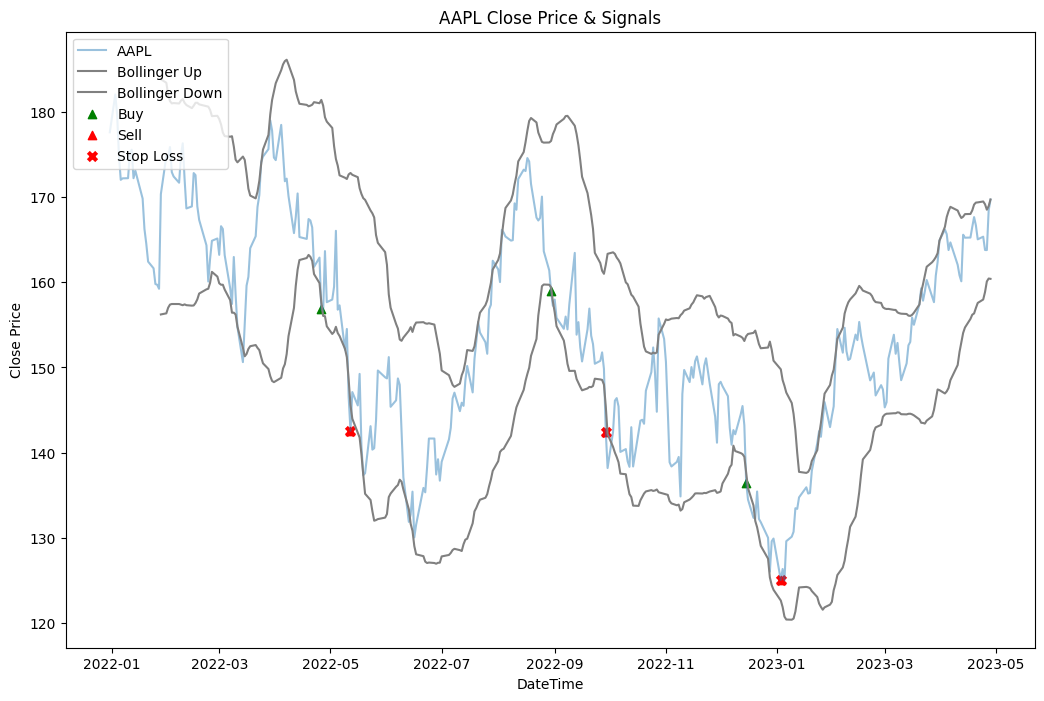

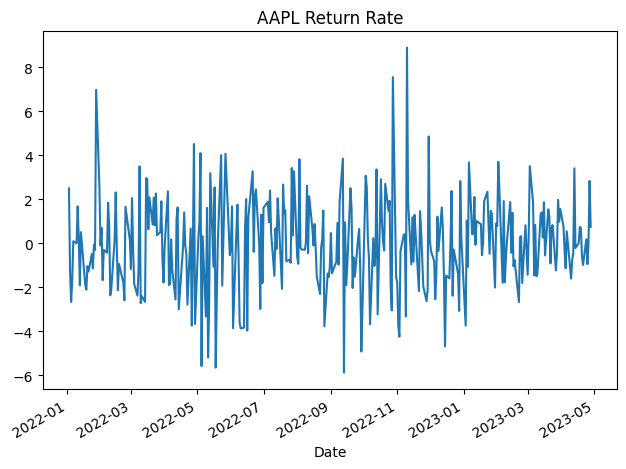

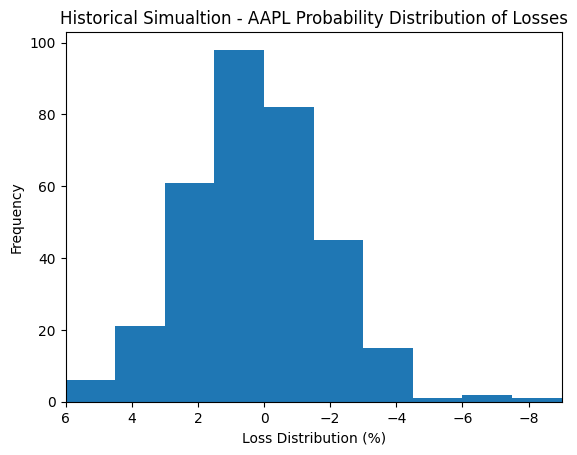

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

class Bollinger_Band:
    """
    A class for analyzing stock data using bb.
    """
    def __init__(self, ticker, start='2015-01-01', end="2022-01-01", sma=20, st=2, stop_loss=True, stop_loss_percent=0.08):
        """
        ticker: stock code
        start: start day
        end: end day
        sma: default: SMA20
        st: default: 2 standard deviation
        stop_loss: Set True if having a stop_loss_percent
        stop_loss_percent: loss percentage compared to the buying price
        """
        self.ticker = ticker
        self.start = start
        self.end = end
        self.sma = sma
        self.st = st
        self.stop_loss = stop_loss
        self.stop_loss_percent = stop_loss_percent

    def download_data(self):
        """
        Download source data
        """
        return yf.download(self.ticker, start=self.start, end=self.end, progress=False).dropna()

    def buy_sell(self, data):
        """
        Buy and Sell signal
        """
        buy_signal = []
        sell_signal = []
        stop_loss_signal = []
        flag = -1
        stop_loss_price = 0
        stop_loss = self.stop_loss
        stop_loss_percent = self.stop_loss_percent
        for i in range(len(data)):
            if data['Ticker'][i] <= data['bollinger_down'][i] and data['Ticker'][i] > stop_loss_price:
                stop_loss_signal.append(np.nan)
                if flag == 0:
                    buy_signal.append(data['Ticker'][i])
                    if stop_loss:
                        stop_loss_price = data['Ticker'][i] * (1 - stop_loss_percent)
                    sell_signal.append(np.nan)
                    flag = 1
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
            elif data['Ticker'][i] >= data['bollinger_up'][i] or data['Ticker'][i] < stop_loss_price:
                if flag == 1:
                    buy_signal.append(np.nan)
                    sell_signal.append(data['Ticker'][i])
                    flag = -1
                    if data['Ticker'][i] < stop_loss_price:
                        stop_loss_signal.append(data['Ticker'][i])
                    else:
                        stop_loss_signal.append(np.nan)
                    stop_loss_price = 0
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
                    stop_loss_signal.append(np.nan)
                if data['Ticker'][i] >= data['bollinger_down'][i]:
                    flag = 0
            else:
                buy_signal.append(np.nan)
                sell_signal.append(np.nan)
                stop_loss_signal.append(np.nan)
        self.data = data
        return buy_signal, sell_signal, stop_loss_signal
    
    def get_bollinger_bands(self, prices):
        
        def get_sma(prices, rate):
            return prices.rolling(rate).mean()
        
        sma = get_sma(prices, self.sma)
        std = prices.rolling(self.sma).std()
        bollinger_up = sma + std * self.st
        bollinger_down = sma - std * self.st
        return bollinger_up, bollinger_down, sma
    
    def historical_simulation(self, data, percentile=0.99):
        latest_price = data['close'].iat[-1]
        number_of_share = 100 / latest_price
        simulation = latest_price * data['close'] / data['close'].shift(1)
        data['loss'] = 100 - simulation * number_of_share
        var_99_percent = data['loss'].quantile(percentile)
        return var_99_percent

    def plot_data(self):
        """
        Plots the stock data and the SMA strategy.
        """
        data = self.data
        plt.figure(figsize=(12.5, 8))
        plt.plot(data['Ticker'], label=self.ticker.upper(), alpha=0.45)
        plt.plot(data['bollinger_up'], label='Bollinger Up', c='gray')
        plt.plot(data['bollinger_down'], label='Bollinger Down', c='gray')
        plt.scatter(data.index, data['Buy_Signal_Price'], label='Buy', marker='^', color='green')
        plt.scatter(data.index, data['Sell_Signal_Price'], label='Sell', marker='^', color='red')
        plt.scatter(data.index, data['Stop_Loss'], label='Stop Loss', marker='x', color='red', linewidth=3)
        plt.legend(loc='upper left')
        plt.title(f'{self.ticker.upper()} Close Price & Signals')
        plt.xlabel('DateTime')
        plt.ylabel('Close Price')
        plt.show()

        data['return'].plot(title=f'{self.ticker} Return Rate')
        plt.tight_layout()
        plt.show()

        # Creating dataset
        import math
        a = np.array(data['loss'])
        rounded_arr = [round(x * 2) / 2 for x in a if not math.isnan(x)]
        counts = {}
        for element in rounded_arr:
            counts[element] = counts.get(element, 0) + 1
        counts = dict(reversed(sorted(counts.items())))
        labels = list(counts.keys())
        values = list(counts.values())
        
        plt.hist(labels, weights=values)
        plt.xlim(max(labels), min(labels))
        plt.xlabel('Loss Distribution (%)')
        plt.ylabel('Frequency')
        plt.title(f'Historical Simualtion - {self.ticker} Probability Distribution of Losses')
        plt.show()

    def historical_simulation(self, data, percentile=0.99):
        latest_price = data['close'].iat[-1]
        number_of_share = 100 / latest_price
        simulation = latest_price * data['close'] / data['close'].shift(1)
        data['loss'] = 100 - simulation * number_of_share
        var_99_percent = data['loss'].quantile(percentile)
        return var_99_percent

    def analyze_performance(self):
        """
        Analyzes the performance of the SMA strategy.
        """
        data = self.data
        buy = data['Buy_Signal_Price'].dropna().reset_index(drop=False)
        sell = data['Sell_Signal_Price'].dropna().reset_index(drop=False)
        stop_loss = data['Stop_Loss'].dropna().reset_index(drop=False)
        merged_df = buy.join(sell, lsuffix='_Buy', rsuffix='_Sell')
        merged_df = merged_df[['Date_Buy', 'Buy_Signal_Price', 'Date_Sell', 'Sell_Signal_Price']].dropna()
        merged_df['Holding Days'] = (merged_df['Date_Sell'] - merged_df['Date_Buy']).dt.days.astype(int)
        merged_df['Profit'] = merged_df['Sell_Signal_Price'] - merged_df['Buy_Signal_Price']
        merged_df['RoR %'] = merged_df['Profit'] / merged_df['Buy_Signal_Price'] * 100
        merged_df['Win'] = (merged_df['Profit'] > 0).astype(int)
        merged_df['Lose'] = (merged_df['Profit'] <= 0).astype(int)
        merged_df['Stop Loss'] = merged_df['Date_Sell'].isin(stop_loss['Date']).astype(int)

        num_trades = len(merged_df)
        profitable_trades = merged_df['Win'].sum()
        losing_trades = merged_df['Lose'].sum()
        total_profit = merged_df['Profit'].sum()
        stop_loss = merged_df['Stop Loss'].sum()
        
        if num_trades > 0:
            win_probability = profitable_trades / num_trades * 100
            average_holding_days = merged_df['Holding Days'].mean()
            average_profit = merged_df['Profit'].mean()
            average_ror = merged_df['RoR %'].mean()
        else:
            win_probability = 0
            average_holding_days = 0
            average_ror = 0
            average_profit = 0

        var_99_percent = self.historical_simulation(data)

        print('Strategy: Bollinger Band')
        print(f"Trades: {num_trades}")
        print(f"Avg holding period: {average_holding_days}")
        print(f"Win trades: {profitable_trades}")
        print(f"Lose trades: {losing_trades}")
        print(f"Stop losses: {stop_loss}")
        print(f"Total profit: {total_profit:.2f}")
        print(f"Avg profit: {average_profit:.2f}")
        print(f"Avg RoR %%: {average_ror:.2f} %")
        print(f"Win rate %: {win_probability}")     
        print(f"1-day 99% VaR: {var_99_percent}")     

        merged_df.rename({'Date_Buy': 'Buy Date', 'Buy_Signal_Price': 'Buy Signal Price', 'Date_Sell': 'Sell Date', 'Sell_Signal_Price': 'Sell Signal Price'}, axis=1, inplace=True)
        merged_df.index += 1
        data_detail = merged_df.round(decimals=2)
        data_detail['Profit'] = data_detail['Profit'].apply(lambda x : x if x < 0 else f'+{x}')
        data_detail['RoR %'] = data_detail['RoR %'].apply(lambda x : x if x < 0 else f'+{x}')
        print(data_detail)

    def show_performance(self):
        df = self.download_data()

        data = pd.DataFrame()
        data['Ticker'] = df['Close']
        data['open'] = df['Open']
        data['high'] = df['High']
        data['low'] = df['Low']
        data['close'] = df['Close']
        data['vol'] = df['Volume']
        data['return'] = 100 * data['close'].pct_change()
        data['bollinger_up'], data['bollinger_down'], data['sma'] = self.get_bollinger_bands(data['Ticker'])
        data['Buy_Signal_Price'], data['Sell_Signal_Price'], data['Stop_Loss']  = self.buy_sell(data)

        self.analyze_performance()
        self.plot_data()

if __name__ == '__main__':
    stock_code = 'AAPL'
    start = '2022-01-01'
    end = '2023-05-01'
    stop_loss = True
    stop_loss_percent = 0.08

    sma = 20
    st = 2
    
    Bollinger_Band(ticker=stock_code, start=start, end=end, sma=sma, st=st, stop_loss=stop_loss, stop_loss_percent=stop_loss_percent).show_performance()


Strategy: MACD
Trades: 9
Avg holding period: 24.22222222222222
Win trades: 4
Lose trades: 5
Stop losses: 1
Total profit: 26.74
Avg profit: 2.97
Avg RoR %%: 2.37 %
Win rate %: 44.44444444444444
1-day 99% VaR: 5.099738736947536
    Buy Date  Buy Signal Price  Sell Date  Sell Signal Price  Holding Days   
1 2022-01-31            174.78 2022-02-17             168.88            17  \
2 2022-03-18            163.98 2022-04-08             170.09            21   
3 2022-05-27            149.64 2022-06-10             137.13            14   
4 2022-06-23            138.27 2022-08-22             167.57            60   
5 2022-10-17            142.41 2022-11-04             138.38            18   
6 2022-11-11            149.70 2022-11-29             141.17            18   
7 2023-01-09            130.15 2023-02-21             148.48            43   
8 2023-03-16            155.85 2023-04-11             160.80            26   
9 2023-04-19            167.63 2023-04-20             166.65            

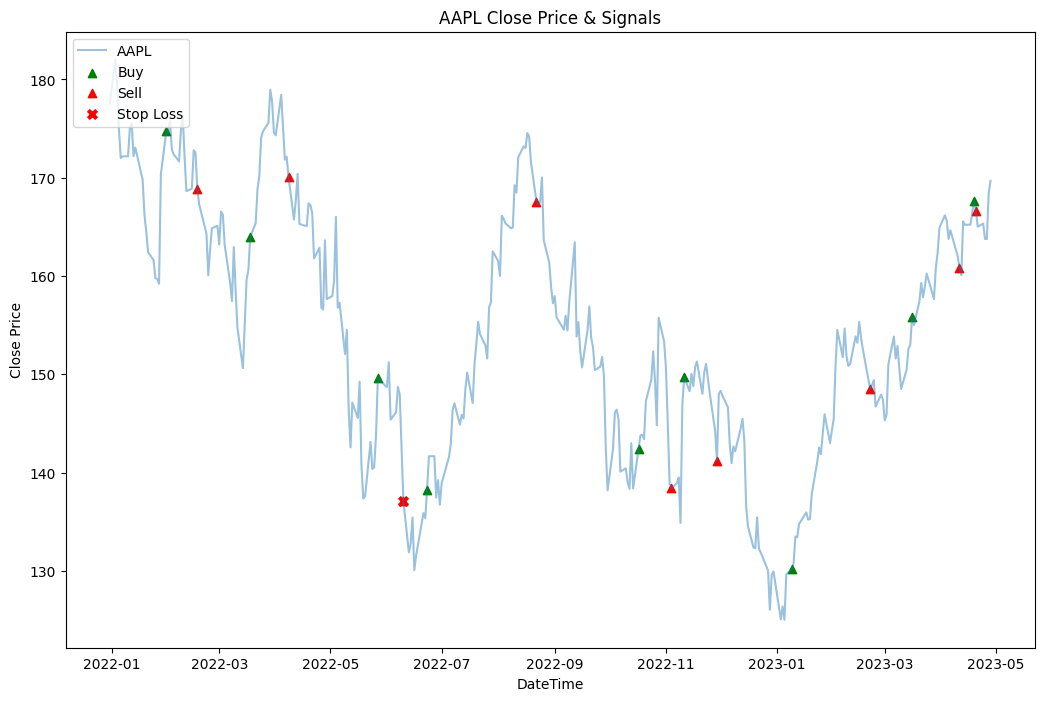

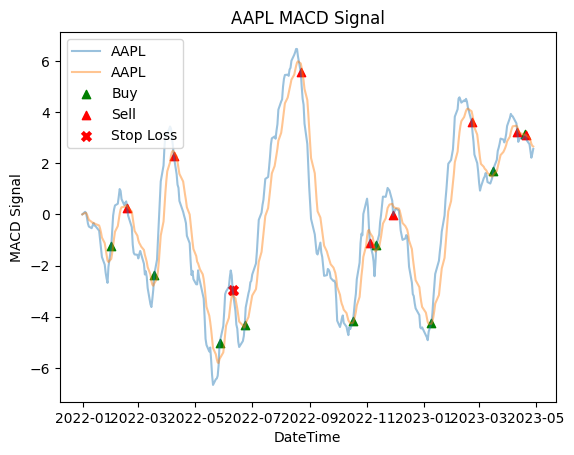

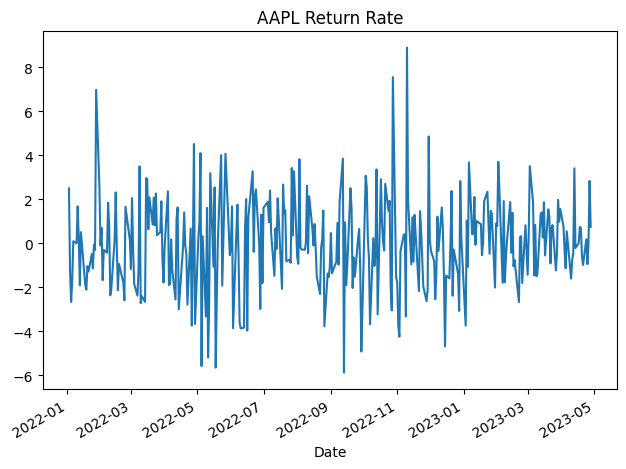

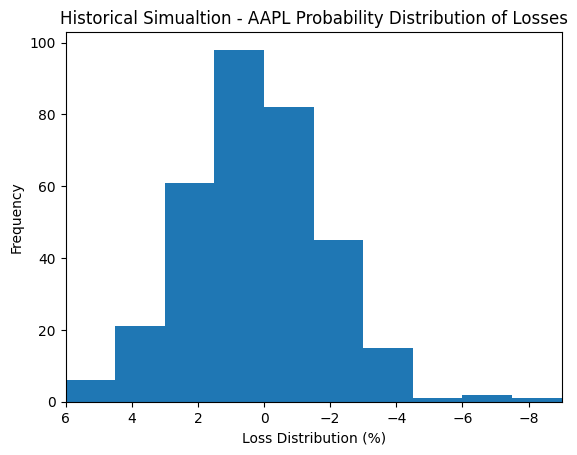

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

class MACD_Strategy:
    """
    A class for analyzing stock data using macd.
    """
    def __init__(self, ticker, start='2015-01-01', end="2022-01-01", ema_short=12, ema_long=26, ema_line=9, stop_loss=True, stop_loss_percent=0.08):
        """
        ticker: stock code
        start: start day
        end: end day
        ema_short: eg.12
        ema_long: eg.26
        ema_line: eg.9
        stop_loss: Set True if having a stop_loss_percent
        stop_loss_percent: loss percentage compared to the buying price
        """
        self.ticker = ticker
        self.start = start
        self.end = end
        self.ema_short = ema_short
        self.ema_long = ema_long
        self.ema_line = ema_line
        self.stop_loss = stop_loss
        self.stop_loss_percent = stop_loss_percent

    def download_data(self):
        """
        Download source data
        """
        return yf.download(self.ticker, start=self.start, end=self.end, progress=False).dropna()

    def buy_sell(self, data):
        """
        Buy and Sell signal
        """
        buy_signal = []
        sell_signal = []
        stop_loss_signal = []
        flag = -1
        stop_loss_price = 0
        stop_loss = self.stop_loss
        stop_loss_percent = self.stop_loss_percent
        for i in range(len(data)):
            if data['EMA MACD'][i] > data['EMA Signal'][i] and data['close'][i] > stop_loss_price:
                stop_loss_signal.append(np.nan)
                if flag == 0:
                    buy_signal.append(data['close'][i])
                    if stop_loss:
                        stop_loss_price = data['close'][i] * (1 - stop_loss_percent)
                    sell_signal.append(np.nan)
                    flag = 1
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
            elif data['EMA MACD'][i] < data['EMA Signal'][i] or data['close'][i] < stop_loss_price:
                if flag == 1:
                    buy_signal.append(np.nan)
                    sell_signal.append(data['close'][i])
                    flag = -1
                    if data['close'][i] < stop_loss_price:
                        stop_loss_signal.append(data['close'][i])
                    else:
                        stop_loss_signal.append(np.nan)
                    stop_loss_price = 0
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
                    stop_loss_signal.append(np.nan)
                if data['EMA MACD'][i] < data['EMA Signal'][i]:
                    flag = 0
            else:
                buy_signal.append(np.nan)
                sell_signal.append(np.nan)
                stop_loss_signal.append(np.nan)
        self.data = data
        return buy_signal, sell_signal, stop_loss_signal

    def historical_simulation(self, data, percentile=0.99):
        latest_price = data['close'].iat[-1]
        number_of_share = 100 / latest_price
        simulation = latest_price * data['close'] / data['close'].shift(1)
        data['loss'] = 100 - simulation * number_of_share
        var_99_percent = data['loss'].quantile(percentile)
        return var_99_percent

    def plot_data(self):
        """
        Plots the stock data and the SMA strategy.
        """
        data = self.data
        plt.figure(figsize=(12.5, 8))
        plt.plot(data['Ticker'], label=self.ticker.upper(), alpha=0.45)
        plt.scatter(data.index, data['Buy_Signal_Price'], label='Buy', marker='^', color='green')
        plt.scatter(data.index, data['Sell_Signal_Price'], label='Sell', marker='^', color='red')
        plt.scatter(data.index, data['Stop_Loss'], label='Stop Loss', marker='x', color='red', linewidth=3)
        plt.legend(loc='upper left')
        plt.title(f'{self.ticker.upper()} Close Price & Signals')
        plt.xlabel('DateTime')
        plt.ylabel('Close Price')
        plt.show()

        data['MACD Buy'] = np.where(data['Buy_Signal_Price'].isna(), np.nan, data[f'EMA MACD'])
        data['MACD Sell'] = np.where(data['Sell_Signal_Price'].isna(), np.nan, data[f'EMA MACD'])
        data['MACD Stop Loss'] = np.where(data['Stop_Loss'].isna(), np.nan, data[f'EMA MACD'])
        plt.plot(data[f'EMA MACD'], label=self.ticker.upper(), alpha=0.45)
        plt.plot(data[f'EMA Signal'], label=self.ticker.upper(), alpha=0.45)
        plt.scatter(data.index, data['MACD Buy'], label='Buy', marker='^', color='green')
        plt.scatter(data.index, data['MACD Sell'], label='Sell', marker='^', color='red')
        plt.scatter(data.index, data['MACD Stop Loss'], label='Stop Loss', marker='x', color='red', linewidth=3)
        plt.legend(loc='upper left')
        plt.title(f'{self.ticker.upper()} MACD Signal')
        plt.xlabel('DateTime')
        plt.ylabel('MACD Signal')
        plt.show()

        data['return'].plot(title=f'{self.ticker} Return Rate')
        plt.tight_layout()
        plt.show()

        # Creating dataset
        import math
        a = np.array(data['loss'])
        rounded_arr = [round(x * 2) / 2 for x in a if not math.isnan(x)]
        counts = {}
        for element in rounded_arr:
            counts[element] = counts.get(element, 0) + 1
        counts = dict(reversed(sorted(counts.items())))
        labels = list(counts.keys())
        values = list(counts.values())
        
        plt.hist(labels, weights=values)
        plt.xlim(max(labels), min(labels))
        plt.xlabel('Loss Distribution (%)')
        plt.ylabel('Frequency')
        plt.title(f'Historical Simualtion - {self.ticker} Probability Distribution of Losses')
        plt.show()

    def historical_simulation(self, data, percentile=0.99):
        latest_price = data['close'].iat[-1]
        number_of_share = 100 / latest_price
        simulation = latest_price * data['close'] / data['close'].shift(1)
        data['loss'] = 100 - simulation * number_of_share
        var_99_percent = data['loss'].quantile(percentile)
        return var_99_percent

    def calculate_macd(self, data):
        ema_12 = data['close'].ewm(span=self.ema_short).mean()
        ema_26 = data['close'].ewm(span=self.ema_long).mean()
        macd_line = ema_12 - ema_26
        signal_line = macd_line.ewm(span=self.ema_line).mean()
        macd_histogram = macd_line - signal_line

        return macd_line, signal_line, macd_histogram

    def analyze_performance(self):
        """
        Analyzes the performance of the SMA strategy.
        """
        data = self.data
        buy = data['Buy_Signal_Price'].dropna().reset_index(drop=False)
        sell = data['Sell_Signal_Price'].dropna().reset_index(drop=False)
        stop_loss = data['Stop_Loss'].dropna().reset_index(drop=False)
        merged_df = buy.join(sell, lsuffix='_Buy', rsuffix='_Sell')
        merged_df = merged_df[['Date_Buy', 'Buy_Signal_Price', 'Date_Sell', 'Sell_Signal_Price']].dropna()
        merged_df['Holding Days'] = (merged_df['Date_Sell'] - merged_df['Date_Buy']).dt.days.astype(int)
        merged_df['Profit'] = merged_df['Sell_Signal_Price'] - merged_df['Buy_Signal_Price']
        merged_df['RoR %'] = merged_df['Profit'] / merged_df['Buy_Signal_Price'] * 100
        merged_df['Win'] = (merged_df['Profit'] > 0).astype(int)
        merged_df['Lose'] = (merged_df['Profit'] <= 0).astype(int)
        merged_df['Stop Loss'] = merged_df['Date_Sell'].isin(stop_loss['Date']).astype(int)

        num_trades = len(merged_df)
        profitable_trades = merged_df['Win'].sum()
        losing_trades = merged_df['Lose'].sum()
        total_profit = merged_df['Profit'].sum()
        stop_loss = merged_df['Stop Loss'].sum()
        
        if num_trades > 0:
            win_probability = profitable_trades / num_trades * 100
            average_holding_days = merged_df['Holding Days'].mean()
            average_profit = merged_df['Profit'].mean()
            average_ror = merged_df['RoR %'].mean()
        else:
            win_probability = 0
            average_holding_days = 0
            average_ror = 0
            average_profit = 0

        var_99_percent = self.historical_simulation(data)

        print('Strategy: MACD')
        print(f"Trades: {num_trades}")
        print(f"Avg holding period: {average_holding_days}")
        print(f"Win trades: {profitable_trades}")
        print(f"Lose trades: {losing_trades}")
        print(f"Stop losses: {stop_loss}")
        print(f"Total profit: {total_profit:.2f}")
        print(f"Avg profit: {average_profit:.2f}")
        print(f"Avg RoR %%: {average_ror:.2f} %")
        print(f"Win rate %: {win_probability}")     
        print(f"1-day 99% VaR: {var_99_percent}")     

        merged_df.rename({'Date_Buy': 'Buy Date', 'Buy_Signal_Price': 'Buy Signal Price', 'Date_Sell': 'Sell Date', 'Sell_Signal_Price': 'Sell Signal Price'}, axis=1, inplace=True)
        merged_df.index += 1
        data_detail = merged_df.round(decimals=2)
        data_detail['Profit'] = data_detail['Profit'].apply(lambda x : x if x < 0 else f'+{x}')
        data_detail['RoR %'] = data_detail['RoR %'].apply(lambda x : x if x < 0 else f'+{x}')
        print(data_detail)

    def show_performance(self):
        df = self.download_data()

        data = pd.DataFrame()
        data['Ticker'] = df['Close']
        data['open'] = df['Open']
        data['high'] = df['High']
        data['low'] = df['Low']
        data['close'] = df['Close']
        data['vol'] = df['Volume']
        data['return'] = 100 * data['close'].pct_change()
        data['EMA MACD'], data['EMA Signal'], data['EMA Histogram'] = self.calculate_macd(data)
        data['Buy_Signal_Price'], data['Sell_Signal_Price'], data['Stop_Loss'] = self.buy_sell(data)

        self.analyze_performance()
        self.plot_data()

if __name__ == '__main__':
    stock_code = 'AAPL'
    start = '2022-01-01'
    end = '2023-05-01'
    stop_loss = True
    stop_loss_percent = 0.08

    ema_short = 12
    ema_long = 26
    ema_line = 9
    
    MACD_Strategy(ticker=stock_code, start=start, end=end, ema_short=ema_short, ema_long=ema_long, ema_line=ema_line, stop_loss=True, stop_loss_percent=0.08).show_performance()


Strategy: RSI
Trades: 4
Avg holding period: 44.5
Win trades: 1
Lose trades: 3
Stop losses: 3
Total profit: -37.34
Avg profit: -9.34
Avg RoR %%: -5.97 %
Win rate %: 25.0
1-day 99% VaR: 5.099738736947536
    Buy Date  Buy Signal Price  Sell Date  Sell Signal Price  Holding Days   
1 2022-04-25            162.88 2022-05-11             146.50            16  \
2 2022-05-24            140.36 2022-07-08             147.04            45   
3 2022-09-01            157.96 2022-09-29             142.48            28   
4 2022-09-30            138.20 2022-12-28             126.04            89   

  Profit  RoR %  Win  Lose  Stop Loss  
1 -16.38 -10.06    0     1          1  
2  +6.68  +4.76    1     0          0  
3 -15.48   -9.8    0     1          1  
4 -12.16   -8.8    0     1          1  


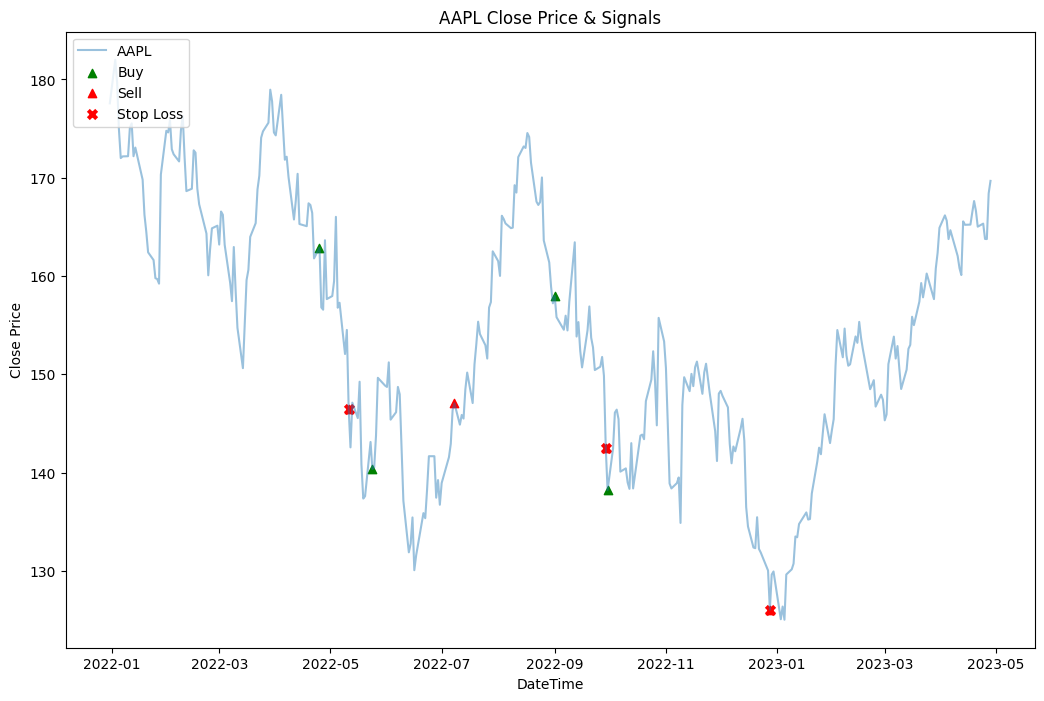

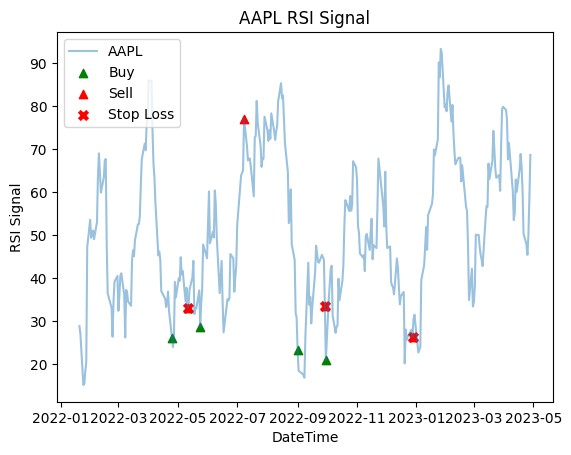

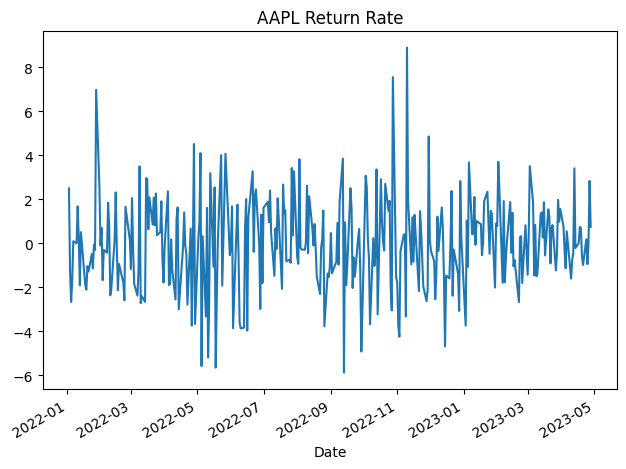

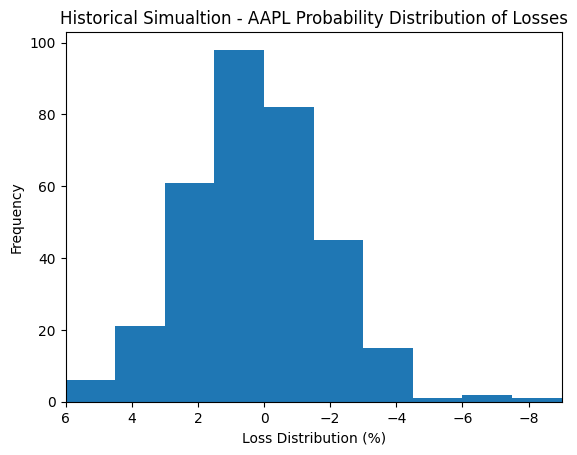

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

class RSI_Strategy:
    """
    A class for analyzing stock data using rsi.
    """
    def __init__(self, ticker, start='2015-01-01', end="2022-01-01", rsi=14, stop_loss=True, stop_loss_percent=0.08):
        """
        ticker: stock code
        start: start day
        end: end day
        rsi: eg.RSI14
        stop_loss: Set True if having a stop_loss_percent
        stop_loss_percent: loss percentage compared to the buying price
        """
        self.ticker = ticker
        self.start = start
        self.end = end
        self.rsi = rsi
        self.stop_loss = stop_loss
        self.stop_loss_percent = stop_loss_percent

    def download_data(self):
        """
        Download source data
        """
        return yf.download(self.ticker, start=self.start, end=self.end, progress=False).dropna()

    def buy_sell(self, data):
        """
        Buy and Sell signal
        """
        buy_signal = []
        sell_signal = []
        stop_loss_signal = []
        flag = -1
        stop_loss_price = 0
        stop_loss = self.stop_loss
        stop_loss_percent = self.stop_loss_percent
        for i in range(len(data)):
            if data[f'RSI{self.rsi}'][i] < 30 and data['close'][i] > stop_loss_price:
                stop_loss_signal.append(np.nan)
                if flag == 0:
                    buy_signal.append(data['close'][i])
                    if stop_loss:
                        stop_loss_price = data['close'][i] * \
                            (1 - stop_loss_percent)
                    sell_signal.append(np.nan)
                    flag = 1
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
            elif data[f'RSI{self.rsi}'][i] > 70 or data['close'][i] < stop_loss_price:
                if flag == 1:
                    buy_signal.append(np.nan)
                    sell_signal.append(data['close'][i])
                    flag = -1
                    if data['close'][i] < stop_loss_price:
                        stop_loss_signal.append(data['close'][i])
                    else:
                        stop_loss_signal.append(np.nan)
                    stop_loss_price = 0
                else:
                    buy_signal.append(np.nan)
                    sell_signal.append(np.nan)
                    stop_loss_signal.append(np.nan)
                if data[f'RSI{self.rsi}'][i] >= 30:
                    flag = 0
            else:
                buy_signal.append(np.nan)
                sell_signal.append(np.nan)
                stop_loss_signal.append(np.nan)
        self.data = data
        return buy_signal, sell_signal, stop_loss_signal

    def historical_simulation(self, data, percentile=0.99):
        latest_price = data['close'].iat[-1]
        number_of_share = 100 / latest_price
        simulation = latest_price * data['close'] / data['close'].shift(1)
        data['loss'] = 100 - simulation * number_of_share
        var_99_percent = data['loss'].quantile(percentile)
        return var_99_percent

    def plot_data(self):
        """
        Plots the stock data and the SMA strategy.
        """
        data = self.data
        plt.figure(figsize=(12.5, 8))
        plt.plot(data['Ticker'], label=self.ticker.upper(), alpha=0.45)
        plt.scatter(data.index, data['Buy_Signal_Price'], label='Buy', marker='^', color='green')
        plt.scatter(data.index, data['Sell_Signal_Price'], label='Sell', marker='^', color='red')
        plt.scatter(data.index, data['Stop_Loss'], label='Stop Loss', marker='x', color='red', linewidth=3)
        plt.legend(loc='upper left')
        plt.title(f'{self.ticker.upper()} Close Price & Signals')
        plt.xlabel('DateTime')
        plt.ylabel('Close Price')
        plt.show()

        data['RSI Buy'] = np.where(data['Buy_Signal_Price'].isna(), np.nan, data[f'RSI{self.rsi}'])
        data['RSI Sell'] = np.where(data['Sell_Signal_Price'].isna(), np.nan, data[f'RSI{self.rsi}'])
        data['RSI Stop Loss'] = np.where(data['Stop_Loss'].isna(), np.nan, data[f'RSI{self.rsi}'])
        plt.plot(data[f'RSI{self.rsi}'], label=self.ticker.upper(), alpha=0.45)
        plt.scatter(data.index, data['RSI Buy'], label='Buy', marker='^', color='green')
        plt.scatter(data.index, data['RSI Sell'], label='Sell', marker='^', color='red')
        plt.scatter(data.index, data['RSI Stop Loss'], label='Stop Loss', marker='x', color='red', linewidth=3)
        plt.legend(loc='upper left')
        plt.title(f'{self.ticker.upper()} RSI Signal')
        plt.xlabel('DateTime')
        plt.ylabel('RSI Signal')
        plt.show()

        data['return'].plot(title=f'{self.ticker} Return Rate')
        plt.tight_layout()
        plt.show()

        # Creating dataset
        import math
        a = np.array(data['loss'])
        rounded_arr = [round(x * 2) / 2 for x in a if not math.isnan(x)]
        counts = {}
        for element in rounded_arr:
            counts[element] = counts.get(element, 0) + 1
        counts = dict(reversed(sorted(counts.items())))
        labels = list(counts.keys())
        values = list(counts.values())
        
        plt.hist(labels, weights=values)
        plt.xlim(max(labels), min(labels))
        plt.xlabel('Loss Distribution (%)')
        plt.ylabel('Frequency')
        plt.title(f'Historical Simualtion - {self.ticker} Probability Distribution of Losses')
        plt.show()

    def historical_simulation(self, data, percentile=0.99):
        latest_price = data['close'].iat[-1]
        number_of_share = 100 / latest_price
        simulation = latest_price * data['close'] / data['close'].shift(1)
        data['loss'] = 100 - simulation * number_of_share
        var_99_percent = data['loss'].quantile(percentile)
        return var_99_percent

    def calculate_rsi(self, data):
        delta = data['close'].diff()
        window_length = self.rsi

        up = delta.where(delta > 0, 0)
        down = -delta.where(delta < 0, 0)

        avg_gain = up.rolling(window_length).mean()
        avg_loss = down.rolling(window_length).mean()

        rs = avg_gain / avg_loss
        rsi = 100.0 - (100.0 / (1.0 + rs))

        return rsi

    def analyze_performance(self):
        """
        Analyzes the performance of the SMA strategy.
        """
        data = self.data
        buy = data['Buy_Signal_Price'].dropna().reset_index(drop=False)
        sell = data['Sell_Signal_Price'].dropna().reset_index(drop=False)
        stop_loss = data['Stop_Loss'].dropna().reset_index(drop=False)
        merged_df = buy.join(sell, lsuffix='_Buy', rsuffix='_Sell')
        merged_df = merged_df[['Date_Buy', 'Buy_Signal_Price', 'Date_Sell', 'Sell_Signal_Price']].dropna()
        merged_df['Holding Days'] = (merged_df['Date_Sell'] - merged_df['Date_Buy']).dt.days.astype(int)
        merged_df['Profit'] = merged_df['Sell_Signal_Price'] - merged_df['Buy_Signal_Price']
        merged_df['RoR %'] = merged_df['Profit'] / merged_df['Buy_Signal_Price'] * 100
        merged_df['Win'] = (merged_df['Profit'] > 0).astype(int)
        merged_df['Lose'] = (merged_df['Profit'] <= 0).astype(int)
        merged_df['Stop Loss'] = merged_df['Date_Sell'].isin(stop_loss['Date']).astype(int)

        num_trades = len(merged_df)
        profitable_trades = merged_df['Win'].sum()
        losing_trades = merged_df['Lose'].sum()
        total_profit = merged_df['Profit'].sum()
        stop_loss = merged_df['Stop Loss'].sum()
        
        if num_trades > 0:
            win_probability = profitable_trades / num_trades * 100
            average_holding_days = merged_df['Holding Days'].mean()
            average_profit = merged_df['Profit'].mean()
            average_ror = merged_df['RoR %'].mean()
        else:
            win_probability = 0
            average_holding_days = 0
            average_ror = 0
            average_profit = 0

        var_99_percent = self.historical_simulation(data)

        print('Strategy: RSI')
        print(f"Trades: {num_trades}")
        print(f"Avg holding period: {average_holding_days}")
        print(f"Win trades: {profitable_trades}")
        print(f"Lose trades: {losing_trades}")
        print(f"Stop losses: {stop_loss}")
        print(f"Total profit: {total_profit:.2f}")
        print(f"Avg profit: {average_profit:.2f}")
        print(f"Avg RoR %%: {average_ror:.2f} %")
        print(f"Win rate %: {win_probability}")     
        print(f"1-day 99% VaR: {var_99_percent}")     

        merged_df.rename({'Date_Buy': 'Buy Date', 'Buy_Signal_Price': 'Buy Signal Price', 'Date_Sell': 'Sell Date', 'Sell_Signal_Price': 'Sell Signal Price'}, axis=1, inplace=True)
        merged_df.index += 1
        data_detail = merged_df.round(decimals=2)
        data_detail['Profit'] = data_detail['Profit'].apply(lambda x : x if x < 0 else f'+{x}')
        data_detail['RoR %'] = data_detail['RoR %'].apply(lambda x : x if x < 0 else f'+{x}')
        print(data_detail)

    def show_performance(self):
        df = self.download_data()

        data = pd.DataFrame()
        data['Ticker'] = df['Close']
        data['open'] = df['Open']
        data['high'] = df['High']
        data['low'] = df['Low']
        data['close'] = df['Close']
        data['vol'] = df['Volume']
        data['return'] = 100 * data['close'].pct_change()
        data[f'RSI{self.rsi}'] = self.calculate_rsi(data)
        data['Buy_Signal_Price'], data['Sell_Signal_Price'], data['Stop_Loss'] = self.buy_sell(data)

        self.analyze_performance()
        self.plot_data()

if __name__ == '__main__':
    stock_code = 'AAPL'
    start = '2022-01-01'
    end = '2023-05-01'
    stop_loss = True
    stop_loss_percent = 0.08

    rsi=14
    
    RSI_Strategy(ticker=stock_code, start=start, end=end, rsi=rsi, stop_loss=stop_loss, stop_loss_percent=stop_loss_percent).show_performance()
